In [1]:
# 한글 설정
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

### 판매량 및 소비자조사 결과 대조

#### 플레이버 별 판매량

ITEM
아이스 고디바 초콜릿     10.30
엄마는 외계인         10.18
민트 초콜릿 칩         6.00
레인보우 샤베트         5.37
뉴욕치즈케이크          5.00
사랑에 빠진 딸기        4.30
아몬드 봉봉(사용안함)     4.17
아몬드 봉봉           4.04
체리쥬빌레            3.84
오레오 쿠키앤크림        3.71
31-요거트           3.65
New 슈팅스타         3.64
베리베리 스트로베리       3.53
바람과함께사라지다        3.30
그린티              2.67
초콜릿 무스           2.26
피스타치오 아몬드        2.15
우.낀.소            2.01
자모카 아몬드 훠지       1.79
망고탱고             1.72
Name: 2112, dtype: float64

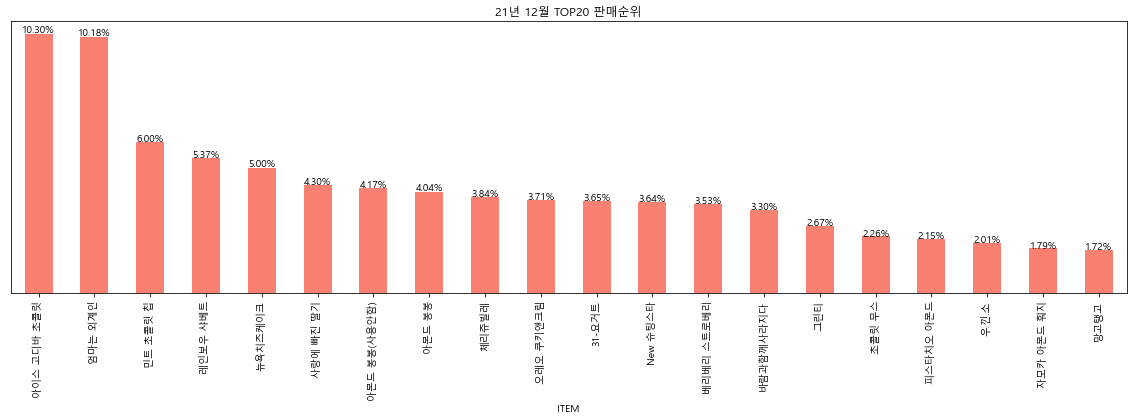

In [2]:
# 10개월(21년2월~12월) 의 판매데이터 활용 
import os
import pandas as pd
path = './dataset'
files = os.listdir(path)[1:]
files = [path+'/'+file for file in files]

df = pd.concat({c.split('/')[-1].split('.')[0]:pd.read_csv(c,encoding= "EUC-KR",index_col=None) for c in files})
df = df.reset_index().drop('level_1', axis=1)
c = ['YYMM', 'CMP_CD', 'ITEM_PLU_CD', 'ITEM', 'SALE_QTY']
df.columns = c
df.ITEM= df.ITEM.apply(lambda x: x.strip()).apply(lambda x: x.replace('\u3000',''))

ITEM = df.ITEM.unique()

def check_name(icecream):
    nm = list(df.ITEM.unique())
    item_d = {str(df[df.ITEM == c]['ITEM_PLU_CD'].unique()[0]):str(c) for c in nm}
    df_item = pd.Series(item_d)
    check = df_item[df_item.str.contains(icecream)]
    return check,f'{len(check)}개'

sale_df = df.pivot_table(values='SALE_QTY',aggfunc='sum',index='YYMM',columns=['ITEM'], margins= True).T.fillna(0).sort_values('All',ascending=False)


    # 비율로 변경, 월별 판매비중 확인
sale_df_ratio = round(sale_df/sale_df.loc['All',:]*100,2)[1:]
yymm = '2112'
Top_no = 20

ax = sale_df_ratio.loc[:,yymm].sort_values(ascending = False)[:Top_no].plot(kind='bar',figsize=(20,5), color ='salmon', title = f'{yymm[:2]}년 {yymm[2:]}월 TOP{Top_no} 판매순위')
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(f"{height:.2f}%" ,(left+width/2, height*1.01), ha='center')
ax.axes.yaxis.set_visible(False)
sale_df_ratio.loc[:,yymm].sort_values(ascending = False)[:Top_no]

#### 소비자 조사

In [3]:
import numpy as np

item = pd.read_csv('./리스트_copy.csv',encoding='euc-kr')
columns = ['조사일자', '제품명', '제품코드', '컨셉만족도', '외관만족도', '맛만족도', '전반만족도', '구매의향', '봄',	'여름',	'가을',	'겨울','비고']
item.columns = columns
item.제품명 = item.제품명.str.strip()
idx = 0
contents = ['ITEM_PLU_CD','SALE_QTY_MM','NO_SALE_MM']
item.iloc[[idx]]

nm2cd = {str(c):str(df[df.ITEM == c]['ITEM_PLU_CD'].unique()[0]) for c in ITEM}

def nm2cd_f(nm):
    try :
        return nm2cd[nm]
    except :
        return np.NaN

item['제품코드'] = item['제품명'].apply(lambda x : nm2cd_f(x))

# 월 평균 판매량 집계 함수 생성
def check_qty(item):
    month = sale_df.loc[item] != 0
    sale_mt_no = len(sale_df.loc[item][month])-1
    max_sales = sale_df.loc[item][:14].max()
    max_sales_month = sale_df.loc[item][:14].argmax()
    return round(sale_df.loc[item]['All'],2),round(sale_df.loc[item]['All']/sale_mt_no,2),sale_mt_no,max_sales,max_sales_month

# 상품별 월평균판매량 정렬
item_d = {idx:[df.ITEM_PLU_CD.unique()[idx], nm, check_qty(nm)[0], check_qty(nm)[1], check_qty(nm)[2],check_qty(nm)[3],check_qty(nm)[4]] for idx, nm in enumerate(df.ITEM.unique())}
item_df = pd.DataFrame(item_d).T
columns=['ITEM_PLU_CD','ITEM_NM','SALE_QTY','SALE_QTY_MM','NO_SALE_MM','SALE_QTY_MAX','SALE_MM_MAX']
item_df.columns = columns
item_df = item_df.fillna(0).sort_values('SALE_QTY_MM',ascending=False)
item_df.to_csv('./output/월별판매량.csv', encoding = 'euc-kr')

def sale(ft,nm):
    try :
        return item_df[item_df['ITEM_NM'] == nm][ft].values[0]
    except :
        return np.NaN
    
item['총판매량'] = item['제품명'].apply(lambda x : sale('SALE_QTY',x))
item['월평균판매량'] = item['제품명'].apply(lambda x : sale('SALE_QTY_MM',x))
item['판매개월수'] = item['제품명'].apply(lambda x : sale('NO_SALE_MM',x))
item['최대월판매량'] = item['제품명'].apply(lambda x : sale('SALE_QTY_MAX',x))
item['최대판매월'] = item['제품명'].apply(lambda x : sale('SALE_MM_MAX',x))
c = ['조사일자', '제품명', '제품코드', '컨셉만족도', '외관만족도', '맛만족도', '전반만족도', '구매의향','총판매량', '월평균판매량', '판매개월수', '최대월판매량', '최대판매월', '봄',	'여름',	'가을',	'겨울', '비고']
item = item[c]
# item.loc[:,:'최대판매월'].fillna(item.median(), inplace = True)
item.to_csv('./output/리스트_.csv', encoding = 'euc-kr')

# 제품코드 없는 항목 날리기 
item_dropna = pd.concat([item[item.제품코드 == c] for c in item.제품코드.dropna()])
item_dropna.to_csv('./output/리스트_dropna.csv', encoding = 'euc-kr')
item_dropna

,조사일자,제품명,제품코드,컨셉만족도,외관만족도,맛만족도,전반만족도,구매의향,총판매량,월평균판매량,판매개월수,최대월판매량,최대판매월,봄,여름,가을,겨울,비고
0,220427,오버더 레인보우 샤베트,A56060,5.1,5.5,5.4,5.4,5.0,1721366.0,143447.17,12.0,900152.0,4.0,0.500,1.000,0.179,0.107,NaN
1,220427,꿀에 빠진 바나나와 망고,A56063,5.3,5.4,5.4,5.3,5.0,986499.0,98649.90,10.0,653041.0,5.0,0.393,0.821,0.321,0.286,NaN
4,220511,꿀에 빠진 바나나와 망고,A56063,5.3,5.5,5.5,5.4,5.3,986499.0,98649.90,10.0,653041.0,5.0,0.607,0.929,0.107,0.107,NaN
16,220525,꿀에 빠진 바나나와 망고,A56063,5.1,5.4,5.3,5.2,5.0,986499.0,98649.90,10.0,653041.0,5.0,0.367,0.850,0.133,0.133,NaN
1,220427,꿀에 빠진 바나나와 망고,A56063,5.3,5.4,5.4,5.3,5.0,986499.0,98649.90,10.0,653041.0,5.0,0.393,0.821,0.321,0.286,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,211213,오레오 쿠키 앤 스트로베리,A56089,5.0,5.3,5.6,5.4,5.5,858187.0,429093.50,2.0,849372.0,13.0,0.767,0.333,0.150,0.600,NaN
48,211117,사랑에 빠진 외계인,A56093,5.8,5.3,5.3,5.2,5.2,6428.0,6428.00,1.0,6428.0,13.0,0.367,0.467,0.350,0.683,NaN
52,211213,사랑에 빠진 외계인,A56093,6.0,5.6,5.3,5.1,4.9,6428.0,6428.00,1.0,6428.0,13.0,0.600,0.567,0.417,0.567,NaN
56,220104,우연한 딸기,A56090,5.0,4.6,4.7,4.5,4.2,285287.0,142643.50,2.0,271348.0,13.0,0.717,0.333,0.100,0.533,상품 2종 비교조사


### Flavor 별 LyfeCycle
 - 기간 : 21년 3월 1일 ~ 22년 3월 31일
 - 데이터 : 전체 거래원장(SBT.TR_SALE_DETAIL) 중 Flavor 데이터선택 데이터 추출 ('A5'로 시작되는 cd)

In [4]:
df1 = pd.read_csv('tocheck1.csv',encoding= "UTF-8",index_col=None) # 21년 데이터
df2 = pd.read_csv('tocheck2.csv',encoding= "UTF-8",index_col=None) # 22년 데이터
c = df1.columns
df2.columns =c
df = pd.concat([df1,df2]) # 병합

# files = ['tocheck1.csv','tocheck2.csv']
# df = pd.concat({c.split('.')[0]:pd.read_csv(c,encoding= "UTF-8",index_col=None) for c in files})

df.ITEM_NM = df.ITEM_NM.astype(str)
df.ITEM_NM= df.ITEM_NM.apply(lambda x: x.strip()).apply(lambda x: x.replace('\u3000','')) # 아이템 이름 앞/뒤 공백 등 삭제
c = ['SALE_DT', 'STOR_CD', 'STORE_NM', 'ITEM_PLU_CD', 'ITEM_NM','QTY']
df.SALE_DT = pd.to_datetime(df['SALE_DT'],format='%Y%m%d') # 날짜 : 계산 위해 datetime으로 변경
df.columns = c
df.reset_index(drop=True, inplace=True) # 인덱스 리셋
df

# df.head()

C:\Users\david\AppData\Local\Temp\ipykernel_9636\3097114568.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('tocheck2.csv',encoding= "UTF-8",index_col=None) # 22년 데이터


,SALE_DT,STOR_CD,STORE_NM,ITEM_PLU_CD,ITEM_NM,QTY
0,2021-03-07,11081,청량리역사,A52342,알폰소 망고,3
1,2021-03-09,11081,청량리역사,A50554,뉴욕치즈케이크,1
2,2021-03-15,11081,청량리역사,A56051,아이스 밀카 초콜릿,2
3,2021-03-17,11081,청량리역사,A50600,초콜릿,3
4,2021-03-26,11081,청량리역사,A56035,아몬드 봉봉,4
...,...,...,...,...,...,...
12514406,2022-03-31,74150,센텀홈플러스,A56089,오레오 쿠키 앤 스트로베리,13
12514407,2022-03-31,74150,센텀홈플러스,A56090,우연한 딸기,3
12514408,2022-03-31,74150,센텀홈플러스,A56091,아이스 바이오 초코링 앤 프로틴볼,10
12514409,2022-03-31,74150,센텀홈플러스,A59964,오레오 쿠키앤크림,5


In [5]:
g = ['ITEM_NM','ITEM_PLU_CD','SALE_DT']
df_s = df.groupby(g)['QTY'].agg('sum').reset_index()
df_s.head()

,ITEM_NM,ITEM_PLU_CD,SALE_DT,QTY
0,31-요거트,A55105,2021-03-01,3285
1,31-요거트,A55105,2021-03-02,2563
2,31-요거트,A55105,2021-03-03,2598
3,31-요거트,A55105,2021-03-04,2378
4,31-요거트,A55105,2021-03-05,3550


In [6]:
# df_s.ITEM_NM.unique(), len(df_s.ITEM_NM.unique())

In [7]:
df_s.describe()

,QTY
count,36116.000000
mean,2522.956335
std,6154.488238
min,1.000000
25%,4.000000
50%,30.000000
75%,2278.250000
max,150040.000000


In [8]:
# from neo4j import GraphDatabase

# """ make node & relationship"""
# def add_article(tx, Category, 베이스, 컨펙션, 리본):
#     tx.run("MERGE (a:NM {Category: $Category , 베이스: $베이스, 컨펙션: $컨펙션, 리본: $리본})",
#            Category=Category, 베이스=베이스, 컨펙션=컨펙션, 리본=리본)


# def add_base(tx):
#     tx.run("MATCH (a:NM) "
#            "MERGE (b:베이스 {name:a.베이스}) "
#            "MERGE (a)<-[r:Publish]-(b)")

# def add_confection(tx):
#     tx.run("MATCH (a:NM) "
#            "MERGE (b:컨펙션 {name:a.컨펙션}) "
#            "MERGE (a)<-[r:Publish]-(b)")
    
# # def add_ribon:
# #     tx.run("MATCH (a:NM) "
# #            "MERGE (b:베이스 {name:a.베이스}) "
# #            "MERGE (a)<-[r:Publish]-(b)")
    
# # def add_confection(tx):
# #     tx.run("MATCH (a:NM) "
# #            "UNWIND a.컨펙션 as k "
# #            "MERGE (b:컨펙션 {name:k}) "
# #            "MERGE (a)-[r:Include]->(b)")


# """ 연결 """
# # Neo4j 브라우저에서 설정한 계정의 ID, PASSWORD를 통해 접속
# greeter = GraphDatabase.driver("neo4j://localhost:7474", auth=("neo4j", "neo4j"))  


# """ 입력 """
# # Cyper code를 이용,  크롤링한 Data를 DB에 입력
# with greeter.session() as session:
#     """ make node """
#     for idx in range(len(df)):
#         session.write_transaction(add_article, base=flavor.iloc[idx]['베이스'],
#                                   confection=flavor.iloc[idx]['컨펙션'], ribon=flavor.iloc[idx]['리본'])
#     session.write_transaction(add_base)
#     session.write_transaction(add_confection)

상품별 판매중 가장 빠른 날짜를 확인, 최초판매일, 판매후 180일 등 마스터테이블 생성

In [9]:
from datetime import timedelta
from datetime import datetime as dt
g2 = ['ITEM_NM', 'ITEM_PLU_CD'] 
df_m = df_s.groupby(g2)['SALE_DT'].agg('min').reset_index().sort_values('SALE_DT')
df_m = df_s.groupby(g2)['SALE_DT'].agg('min').reset_index().sort_values('SALE_DT')
df_m['180_SALE_DT'] = df_m.SALE_DT.apply(lambda x : x+timedelta(days=180))
c = ['ITEM_NM','ITEM_PLU_CD','F_SALE_DT','180_SALE_DT']
df_m.columns = c
df_m

,ITEM_NM,ITEM_PLU_CD,F_SALE_DT,180_SALE_DT
0,31-요거트,A55105,2021-03-01,2021-08-28
116,에스프레소 앤 크림,A51122,2021-03-01,2021-08-28
123,오레오 쿠키앤크림,A59964,2021-03-01,2021-08-28
52,바닐라,A50649,2021-03-01,2021-08-28
51,바나나 피칸,A50159,2021-03-01,2021-08-28
...,...,...,...,...
73,소금 우유 아이스크림,A56088,2022-02-12,2022-08-11
128,우연한 딸기,A56090,2022-02-24,2022-08-23
120,오레오 쿠키 앤 스트로베리,A56089,2022-02-24,2022-08-23
100,아이스 바이오 초코링 앤 프로틴볼,A56091,2022-03-21,2022-09-17


가장 빠른 날짜인 '210301'에도 판매중인 제품은 permanant, 그 외에는 new로 정리

In [10]:
permenent = df_m[df_m.F_SALE_DT=='2021-03-01']['ITEM_PLU_CD'].unique()
new = list(set(df_m['ITEM_PLU_CD'].unique()) - set(permenent))

permenent = df_m[df_m.F_SALE_DT=='2021-03-01']['ITEM_PLU_CD'].unique()
new = list(set(df_m['ITEM_PLU_CD'].unique()) - set(permenent))

def type_new(c):
    if c in permenent:
        return 'permenent'
    elif c in new:
        return 'new'
    else:
        pass
    
df_s['CAT'] = df_s.ITEM_PLU_CD.apply(lambda x : type_new(x))
df_s = df_s[['ITEM_NM', 'ITEM_PLU_CD', 'CAT','SALE_DT', 'QTY']]
df_s

,ITEM_NM,ITEM_PLU_CD,CAT,SALE_DT,QTY
0,31-요거트,A55105,permenent,2021-03-01,3285
1,31-요거트,A55105,permenent,2021-03-02,2563
2,31-요거트,A55105,permenent,2021-03-03,2598
3,31-요거트,A55105,permenent,2021-03-04,2378
4,31-요거트,A55105,permenent,2021-03-05,3550
...,...,...,...,...,...
36111,후르츠 환타지,A50891,new,2022-02-12,1
36112,후르츠 환타지,A50891,new,2022-02-13,4
36113,후르츠 환타지,A50891,new,2022-02-21,1
36114,후르츠 환타지,A50891,new,2022-03-13,1


ITEM_NM
엄마는 외계인         10027065
민트 초콜릿 칩         5665495
아몬드 봉봉           5524936
레인보우 샤베트         4669931
뉴욕치즈케이크          4601318
사랑에 빠진 딸기        3597272
체리쥬빌레            3553425
31-요거트           3455812
오레오 쿠키앤크림        3403066
베리베리 스트로베리       3070953
바람과함께사라지다        2951807
그린티              2395555
아몬드 봉봉(사용안함)     2059335
피스타치오 아몬드        1891784
초코나무 숲           1866987
슈팅스타             1725211
초콜릿              1612921
초콜릿 무스           1597576
바닐라              1434311
이상한 나라의 솜사탕      1049501
쫀떡궁합              952948
자모카 아몬드 훠지        839812
월넛                577154
러브미               351729
아이스 허니버터 아몬드      300171
알폰소 망고            249911
블랙 소르베            249618
에스프레소 앤 크림        215369
럭키 카라멜 터틀         210490
핑크러브              206227
Name: QTY, dtype: int64


<AxesSubplot:title={'center':'Permanent top30'}, xlabel='ITEM_NM'>

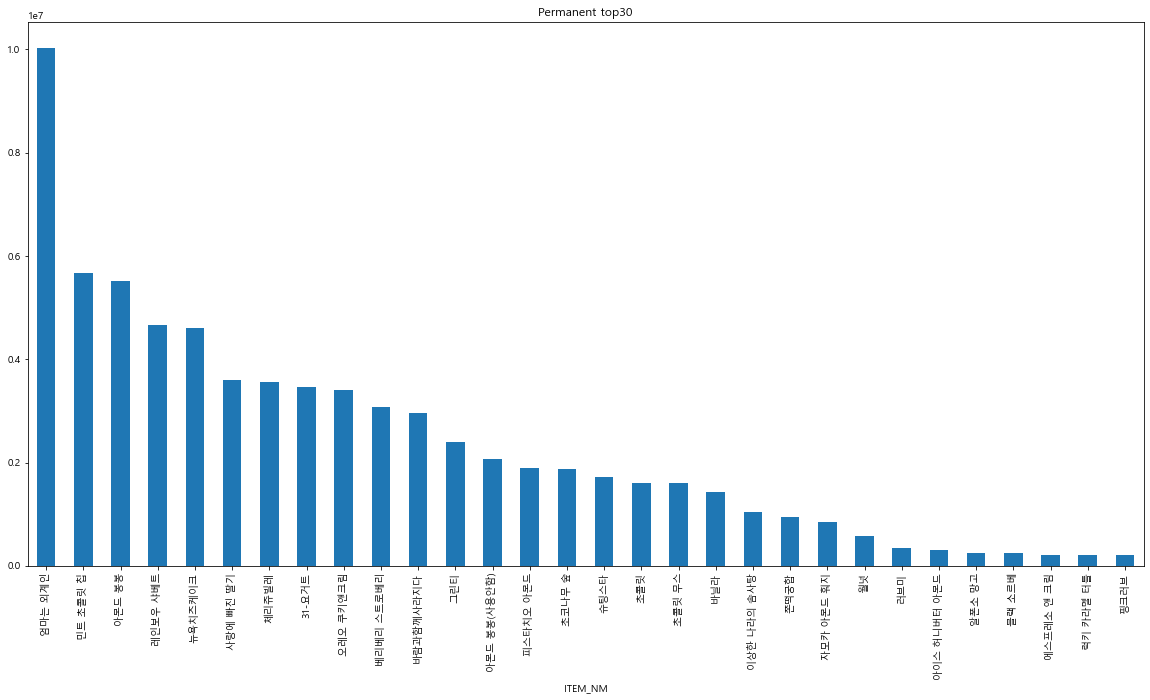

In [11]:
print(df_s[df_s.CAT=='permenent'].groupby(['ITEM_NM'])['QTY'].sum().sort_values(ascending=False)[:30])
df_s[df_s.CAT=='permenent'].groupby(['ITEM_NM'])['QTY'].sum().sort_values(ascending=False)[:30].plot(title = 'Permanent top30', kind='bar', figsize = (20,10))

ITEM_NM
New 슈팅스타           2092685
NEW 이상한 나라의 솜사탕    1245532
아이스 로아커            1030620
New 자모카 아몬드 훠지     1002217
오레오 쿠키 앤 스트로베리      858187
기운 센 아이스 콘푸로스트      821770
오버더 레인보우 샤베트        771062
찰떡 콩떡               754759
너는 참 달고나            748141
아이스 고디바 초콜릿         582057
망고탱고                560163
민트 초코 봉봉            528278
아이스 꼬북칩             477566
치즈 고구마구마            463443
아이스 홈런볼             454256
치즈나무 숲              435361
애플 민트               433604
오레오 쿠키 앤 크림치즈       392881
꿀에 빠진 바나나와 망고       380803
오레오 쿠키 앤 민트         328015
마법사의 할로윈            303178
우연한 딸기              285287
파핑 파핑 바나나           245080
소금 우유 아이스크림         221007
트리플 치즈 러브           217543
초코 아몬드 봉봉           216522
워싱턴 블루베리 쥬빌레        205556
레드 라즈베리 소르베         205386
디노젤리                205264
아이스 맥심 모카골드         204040
Name: QTY, dtype: int64


<AxesSubplot:title={'center':'New top30'}, xlabel='ITEM_NM'>

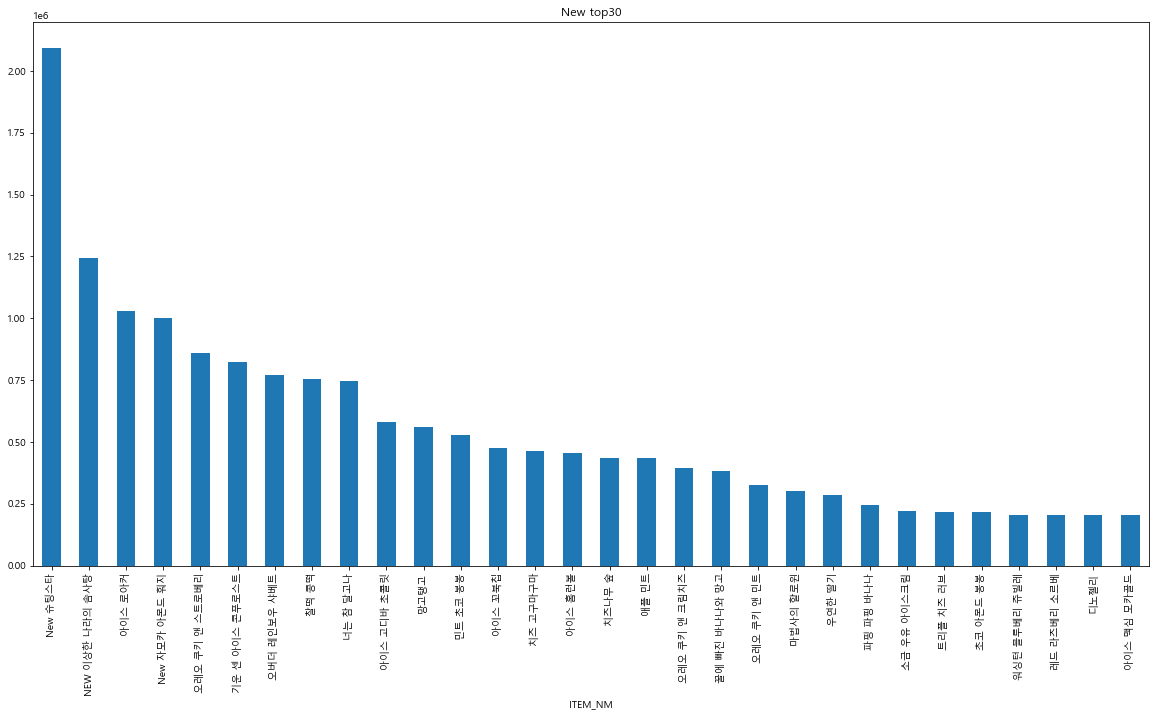

In [12]:
print(df_s[df_s.CAT=='new'].groupby(['ITEM_NM'])['QTY'].sum().sort_values(ascending=False)[:30])
df_s[df_s.CAT=='new'].groupby(['ITEM_NM'])['QTY'].sum().sort_values(ascending=False)[:30].plot(title = 'New top30', kind='bar', figsize = (20,10))

In [13]:
new_top30 = list(df_s[df_s.CAT=='new'].groupby(['ITEM_NM'])['QTY'].sum().sort_values(ascending=False)[:30].index)
new_bottom30 = list(df_s[df_s.CAT=='new'].groupby(['ITEM_NM'])['QTY'].sum().sort_values(ascending=False)[-30:].index)
new_30to80 = list(df_s[df_s.CAT=='new'].groupby(['ITEM_NM'])['QTY'].sum().sort_values(ascending=False)[30:-55].index)

In [14]:
new_nm = ['New 슈팅스타', 'NEW 이상한 나라의 솜사탕', 'New 자모카 아몬드 훠지', '오버더 레인보우 샤베트', '찰떡 콩떡', '너는 참 달고나', '아이스 고디바 초콜릿', '망고탱고', '민트 초코 봉봉', '치즈 고구마구마',
 '치즈나무 숲', '애플 민트', '꿀에 빠진 바나나와 망고', '우연한 딸기', '파핑 파핑 바나나', '소금 우유 아이스크림', '트리플 치즈 러브', '초코 아몬드 봉봉', '워싱턴 블루베리 쥬빌레', '레드 라즈베리 소르베', '디노젤리']
[df_s[df_s.ITEM_NM == c]['ITEM_PLU_CD'].unique()[0] for c in new_nm]

['A56077',
 'A56076',
 'A56083',
 'A56060',
 'A56073',
 'A52420',
 'A56081',
 'A50594',
 'A56057',
 'A56079',
 'A56080',
 'A51080',
 'A56063',
 'A56090',
 'A52095',
 'A56088',
 'A52438',
 'A56036',
 'A56003',
 'A51010',
 'A52197']

첫판매 후 180간의 데이터만 별도 테이블 생성

In [15]:
df_sm = df_s.join(df_m.set_index('ITEM_NM')[['F_SALE_DT','180_SALE_DT']], on ='ITEM_NM')
df_sm = df_sm[(df_sm.CAT =='new') &(df_sm.SALE_DT >= df_sm.F_SALE_DT) & (df_sm.SALE_DT <= df_sm['180_SALE_DT'])].reset_index(drop = True) # 신제품 의 판매후 180일 판매수량 수집
df_sm['l_dt'] = (df_sm['SALE_DT']-df_sm['F_SALE_DT'] + timedelta(days=1)).dt.days
df_sm

,ITEM_NM,ITEM_PLU_CD,CAT,SALE_DT,QTY,F_SALE_DT,180_SALE_DT,l_dt
0,31올스타,A52403,new,2021-03-02,1,2021-03-02,2021-08-29,1
1,31올스타,A52403,new,2021-03-04,1,2021-03-02,2021-08-29,3
2,31올스타,A52403,new,2021-03-12,4,2021-03-02,2021-08-29,11
3,31올스타,A52403,new,2021-03-27,1,2021-03-02,2021-08-29,26
4,31올스타,A52403,new,2021-04-03,1,2021-03-02,2021-08-29,33
...,...,...,...,...,...,...,...,...
11233,후르츠 환타지,A50891,new,2021-07-03,1,2021-03-06,2021-09-02,120
11234,후르츠 환타지,A50891,new,2021-07-17,2,2021-03-06,2021-09-02,134
11235,후르츠 환타지,A50891,new,2021-07-31,2,2021-03-06,2021-09-02,148
11236,후르츠 환타지,A50891,new,2021-08-14,7,2021-03-06,2021-09-02,162


#### Top30의 LifeCycle조회/저장

C:\dev\Miniconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


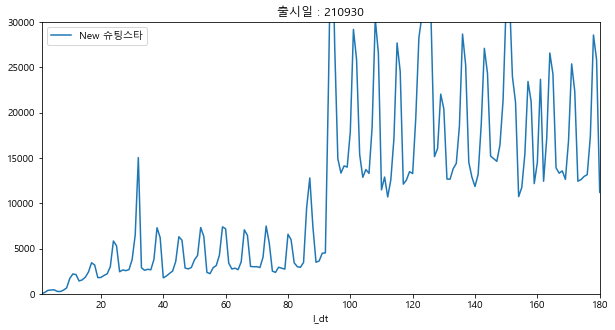

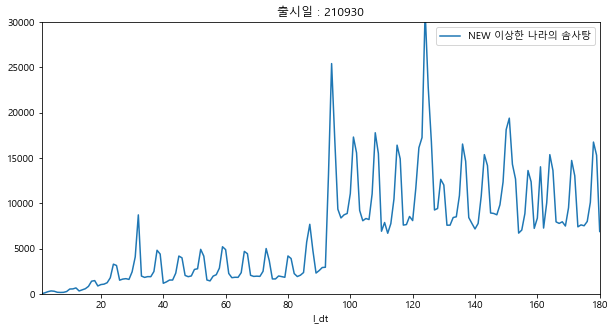

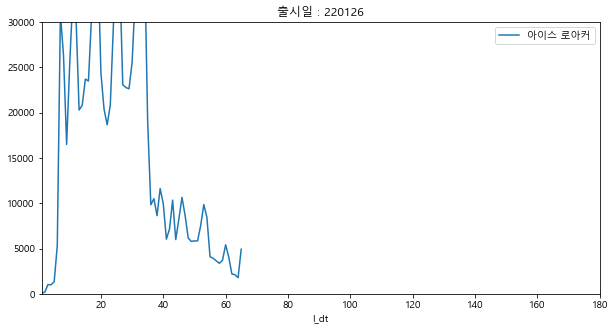

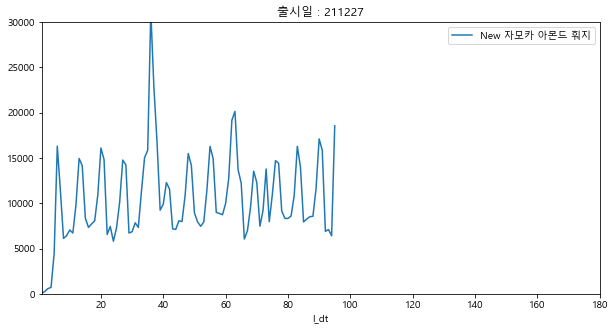

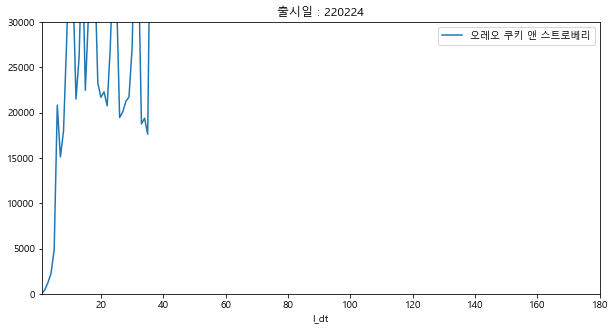

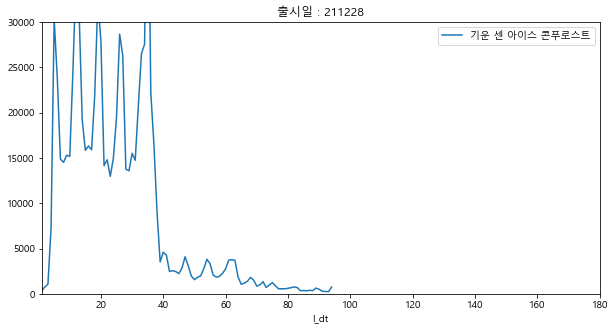

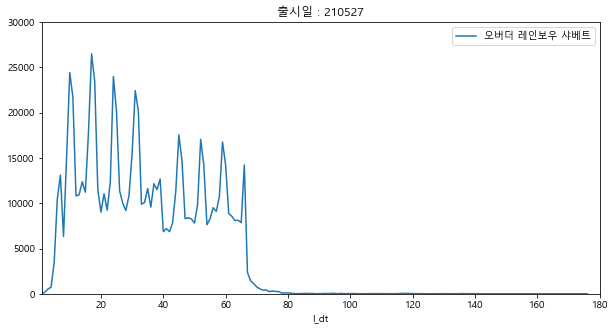

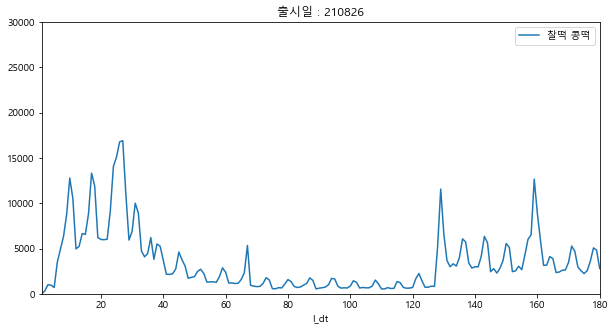

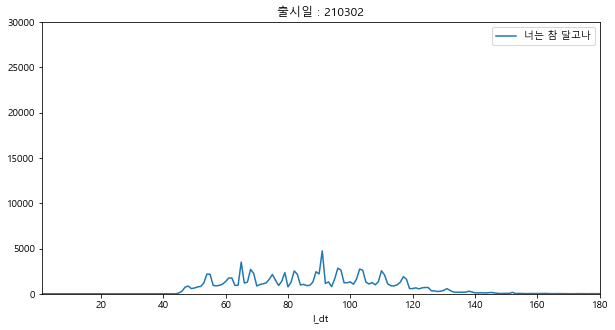

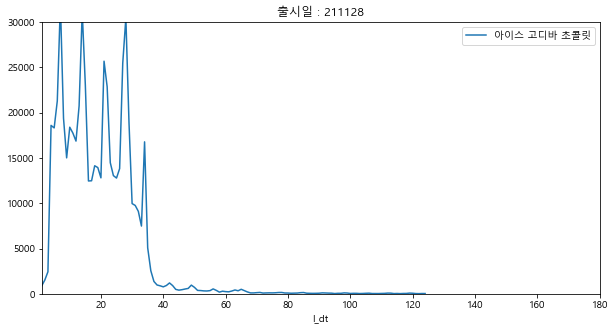

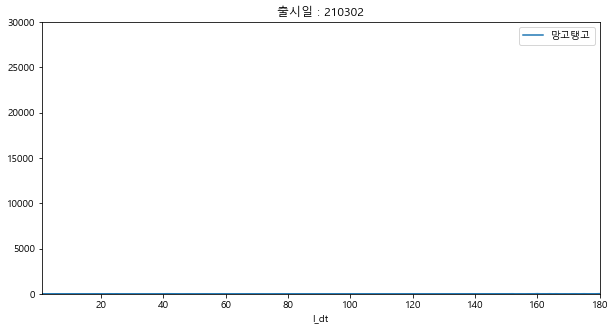

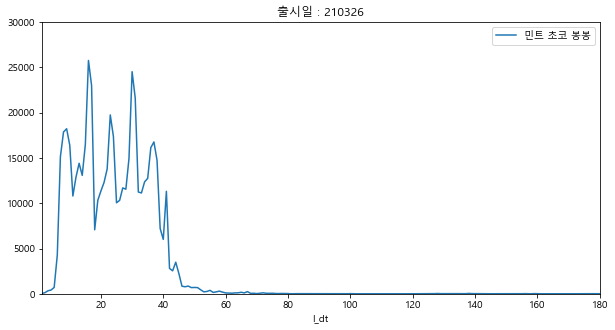

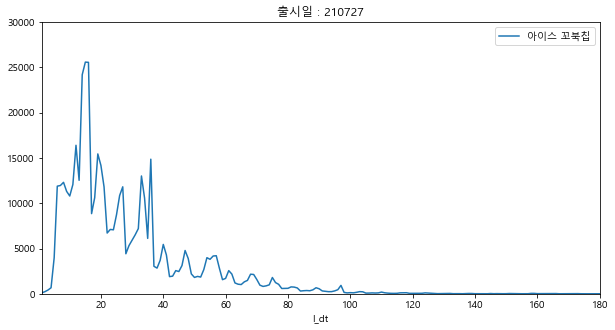

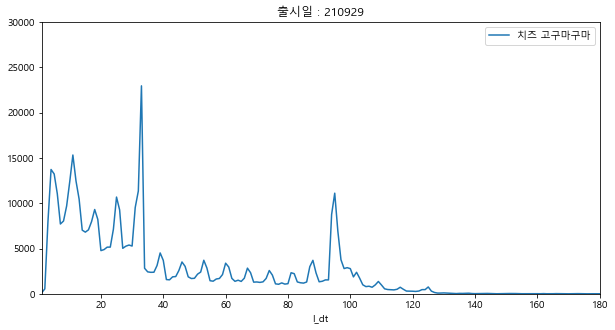

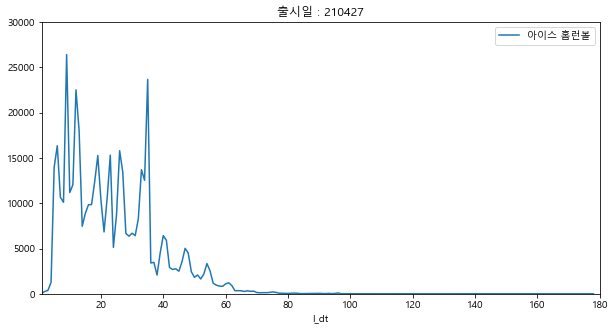

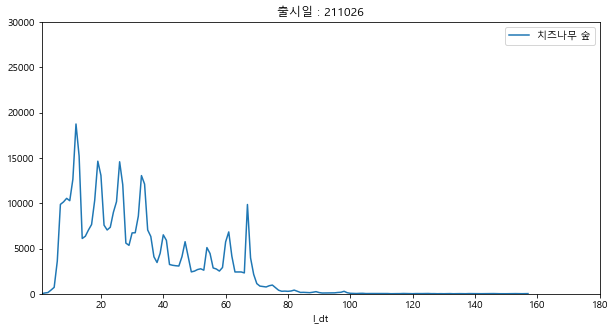

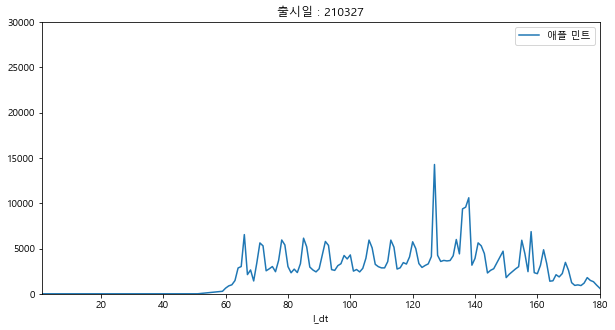

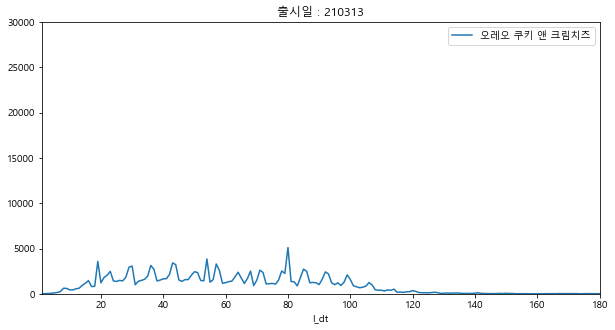

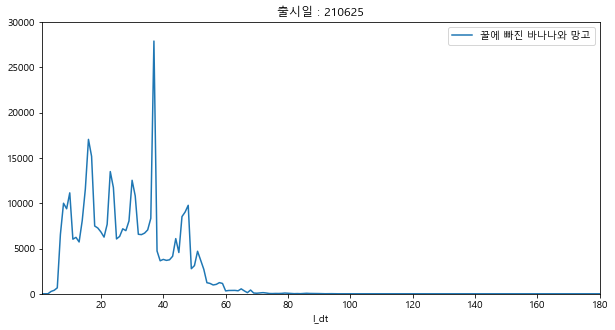

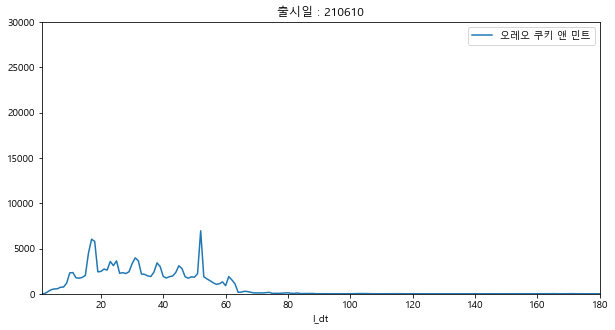

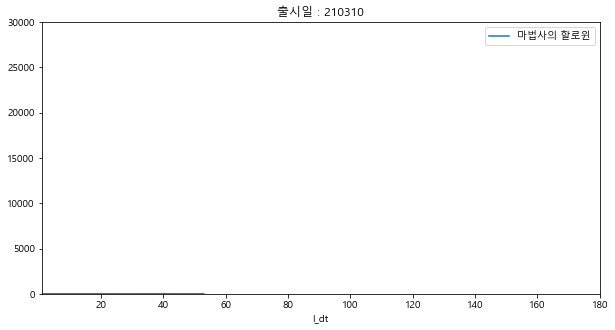

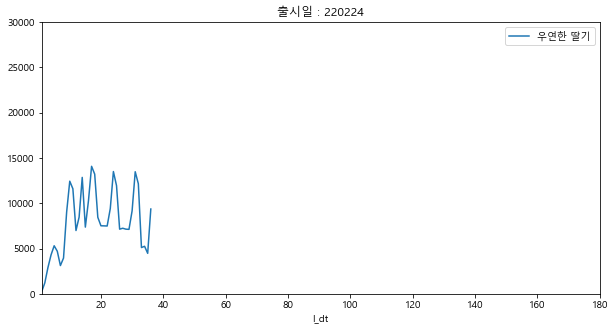

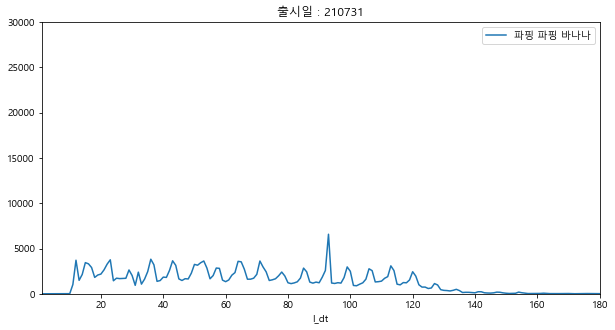

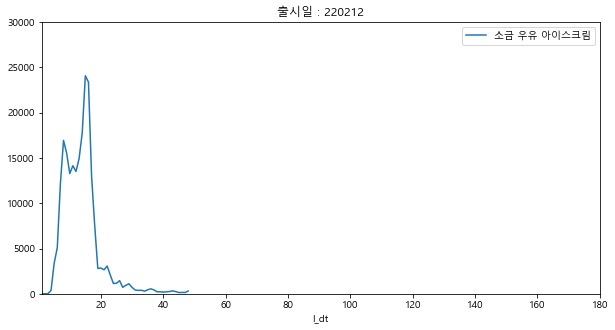

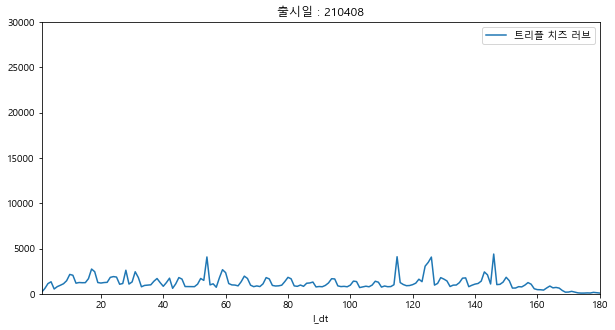

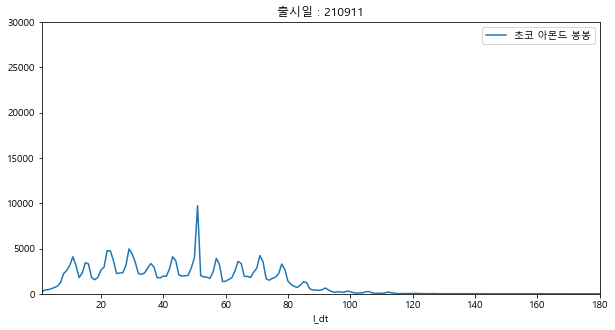

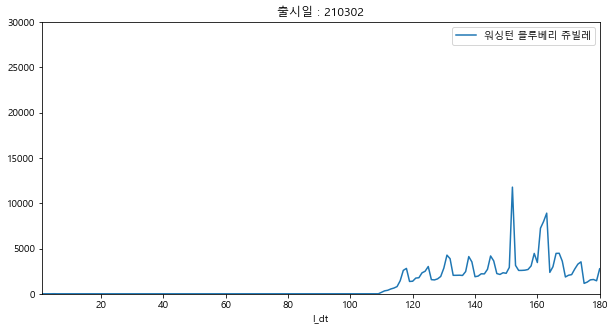

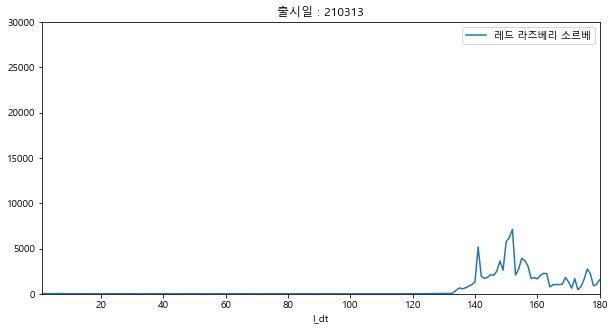

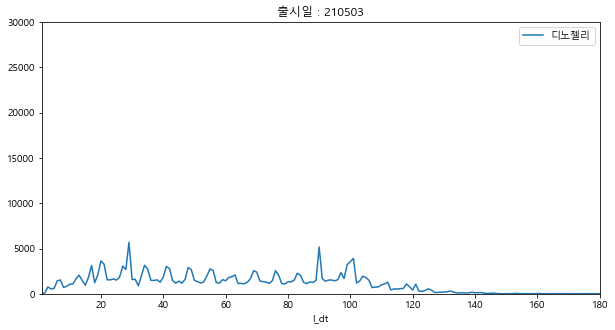

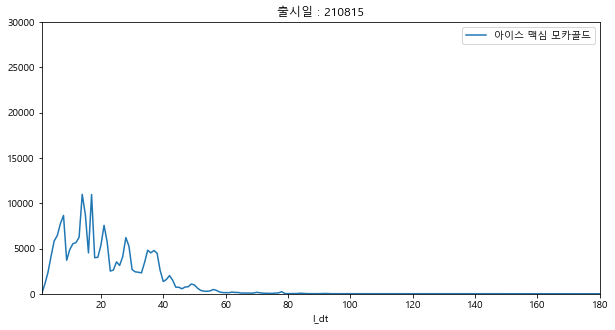

In [16]:
for idx, c in enumerate(new_top30):
    # plt.subplot(6,5,idx+1)
    # df_sm[df_sm.ITEM_NM==c].plot(y = 'QTY', x ='l_dt', label = c, figsize = (10,5))
    title = df_m[df_m.ITEM_NM==c]['F_SALE_DT'].dt.strftime('%y%m%d').values[0]
    df_sm[df_sm.ITEM_NM==c].plot(y = 'QTY', x ='l_dt',title= f'출시일 : {title}' ,label = c, figsize = (10,5), xlim = [1,180], ylim = [0,30000])
    plt.savefig(f'./output/fom_lifecycle/t1_{idx+1}_fom_{c}.png', bbox_inches = 'tight')

#### Top80위권 LifeCycle 조회/저장

C:\dev\Miniconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


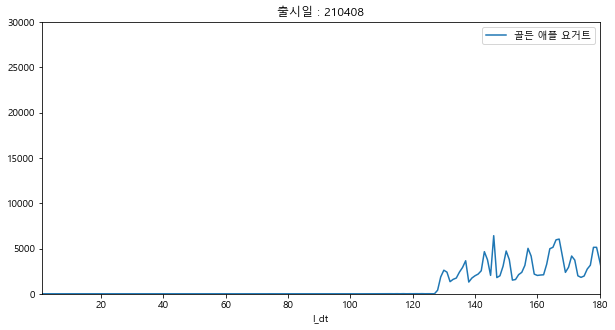

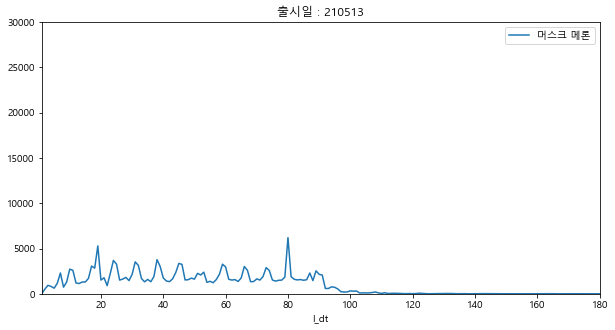

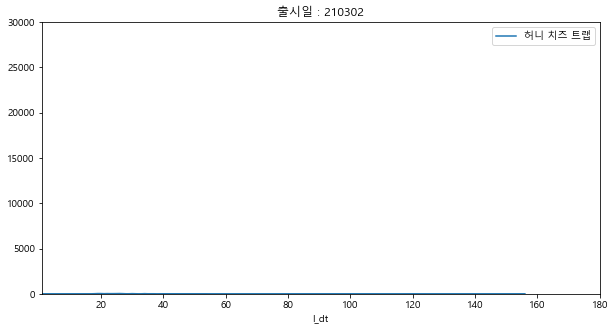

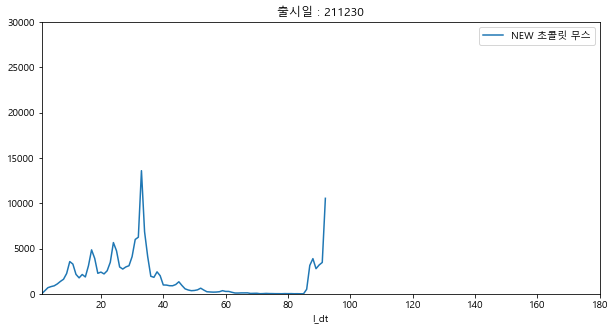

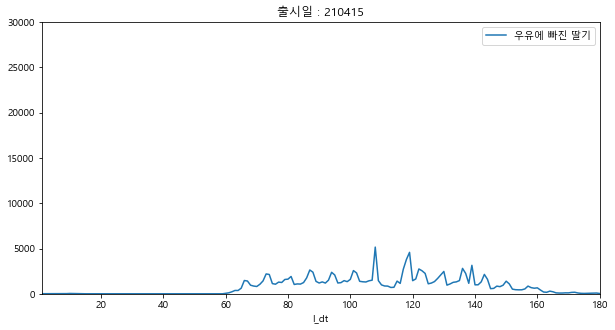

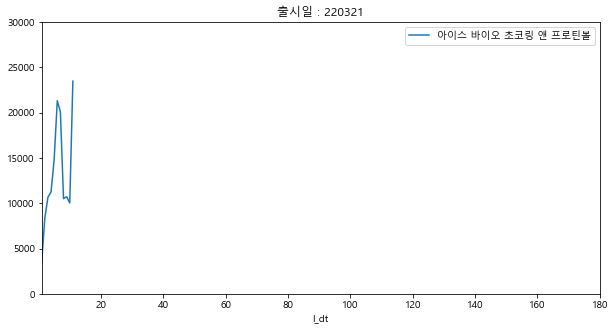

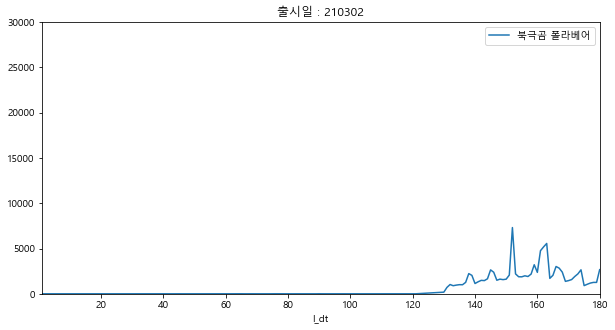

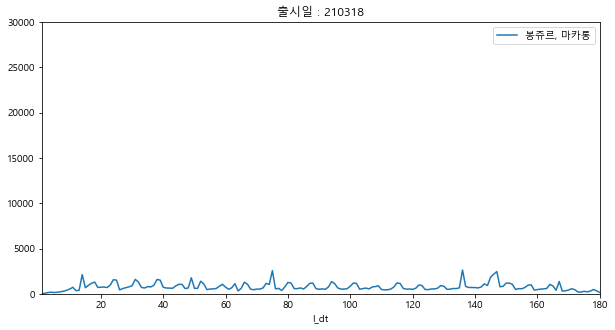

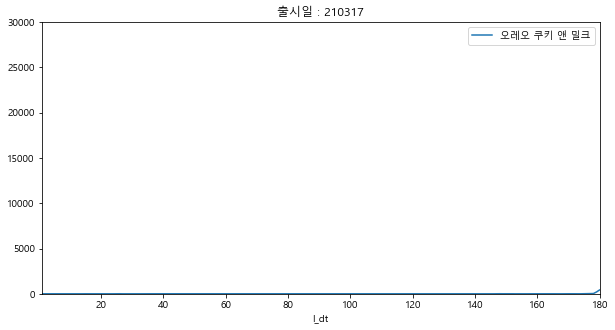

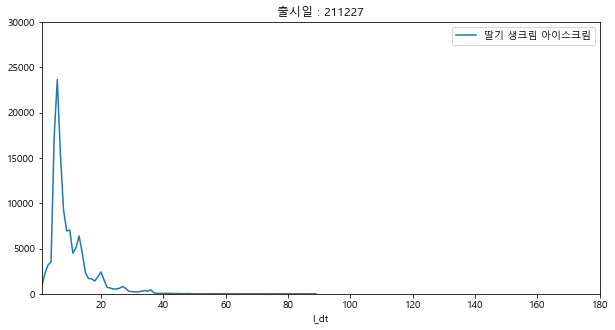

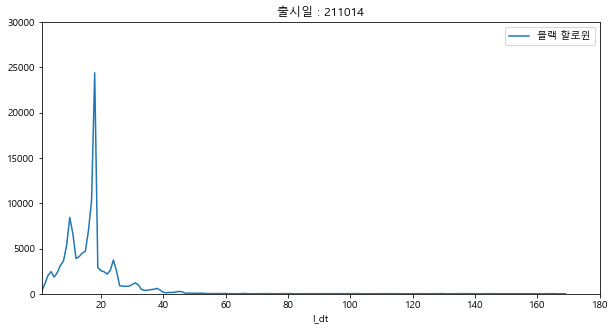

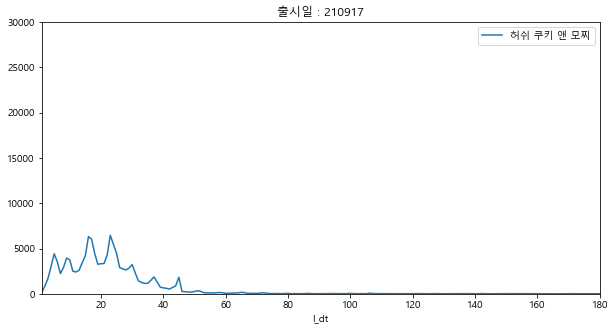

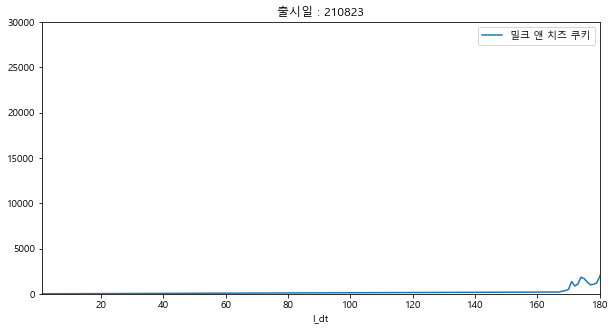

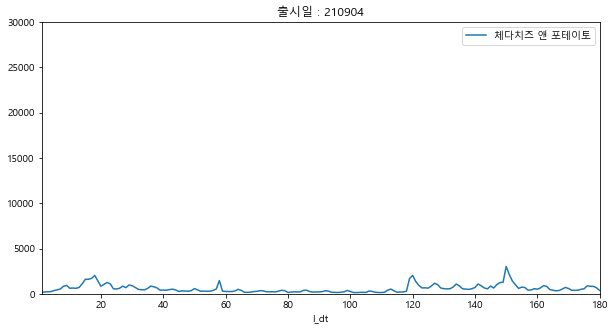

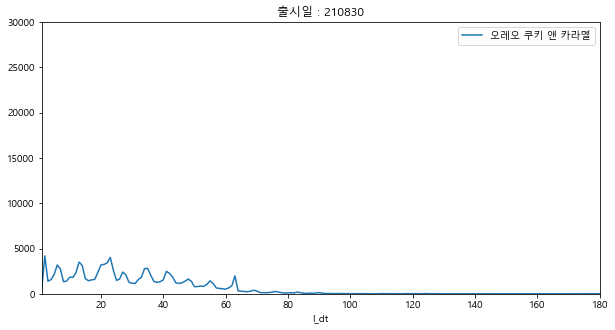

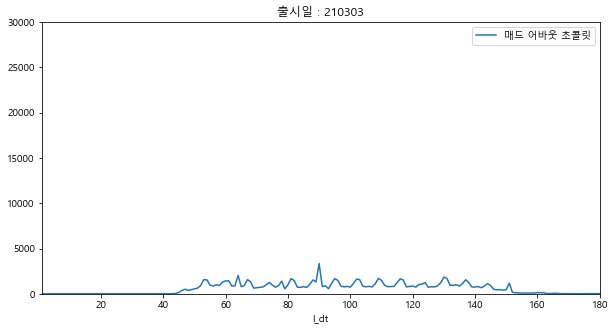

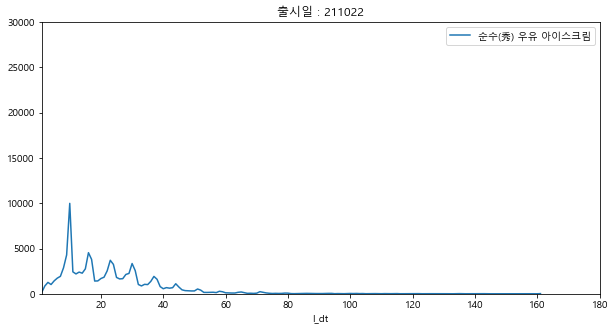

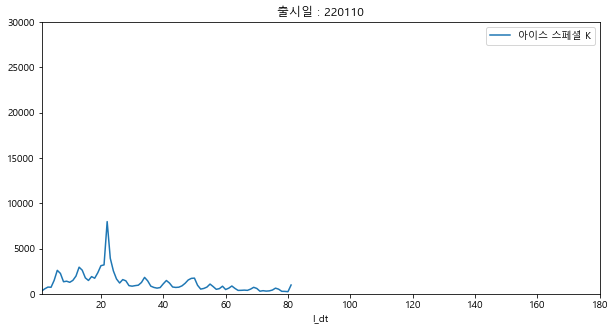

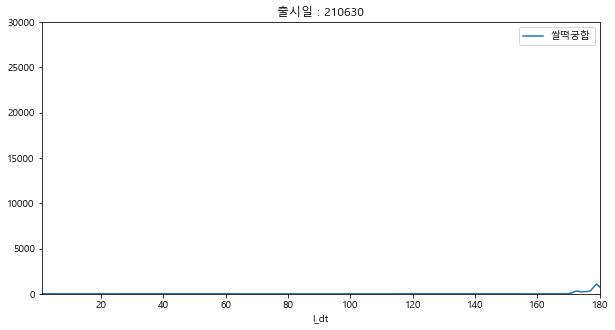

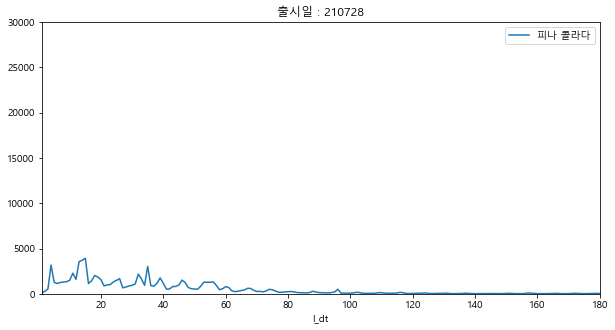

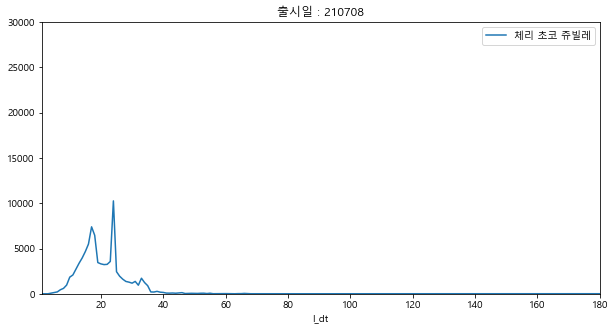

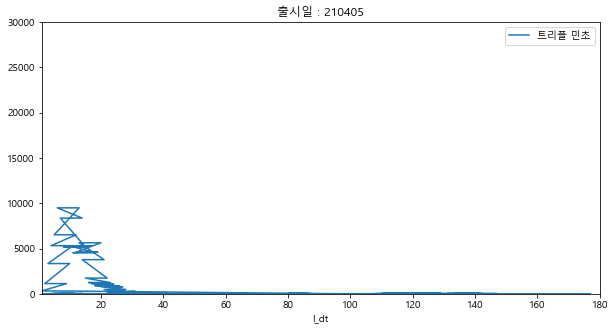

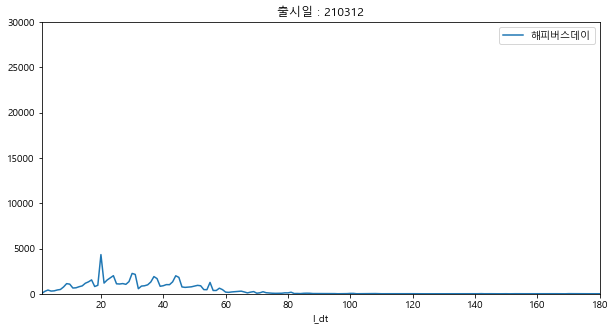

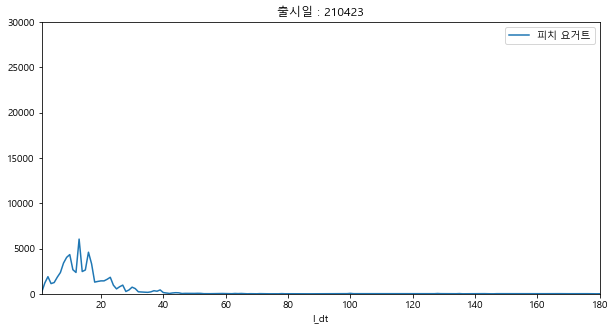

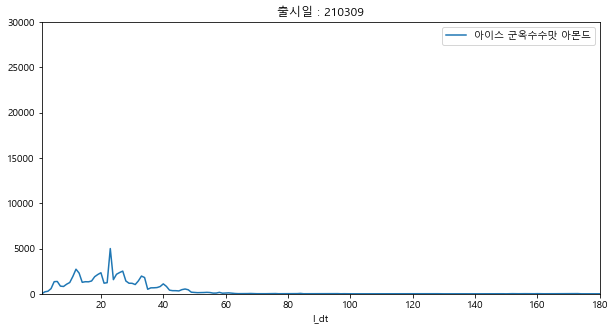

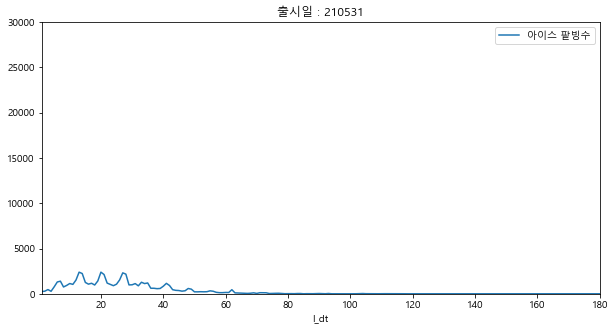

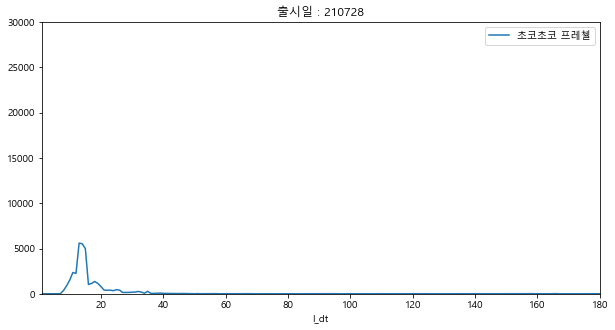

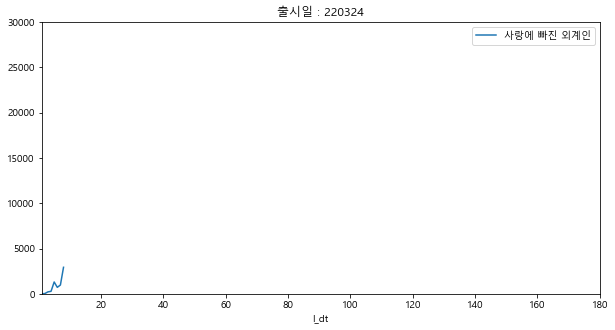

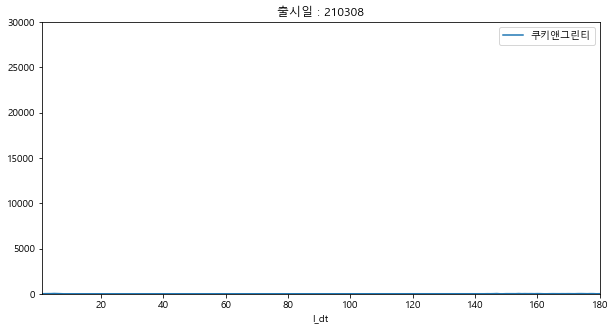

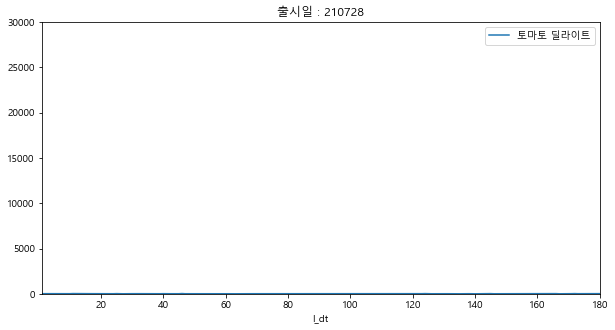

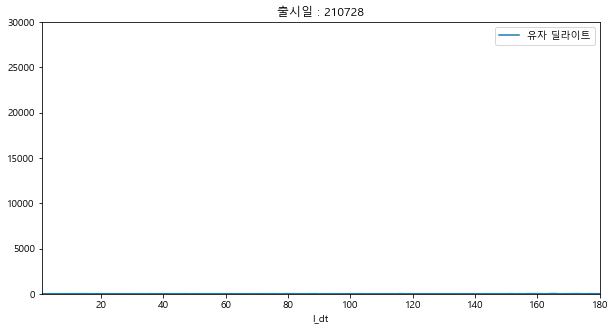

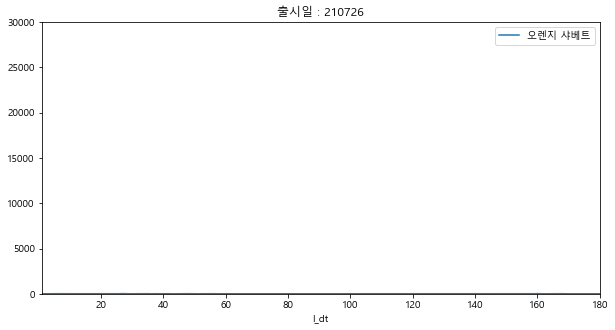

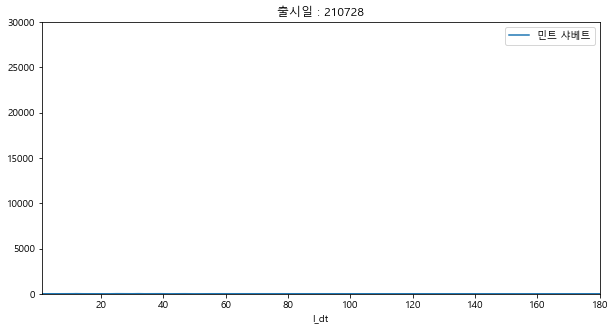

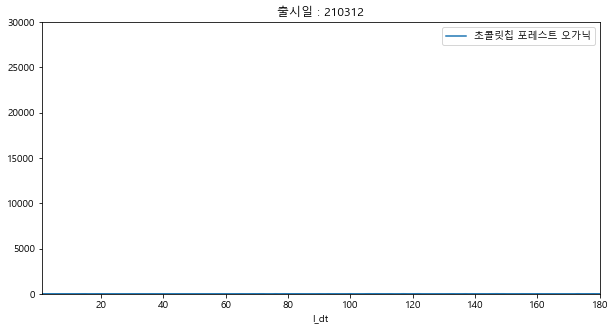

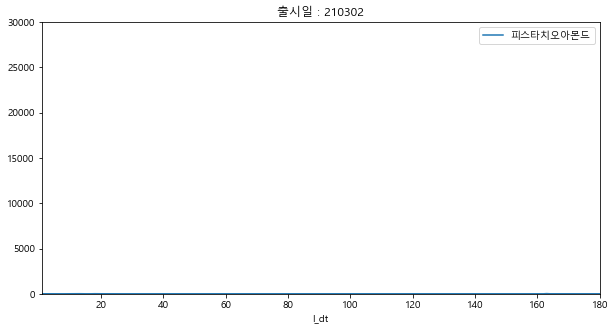

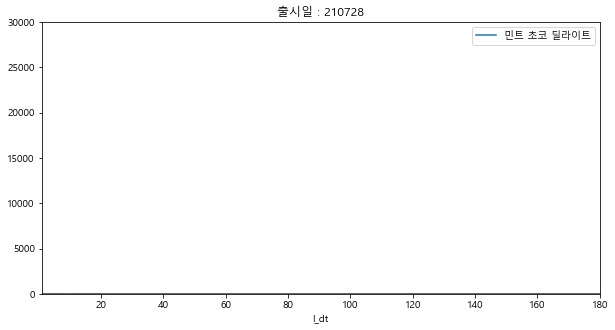

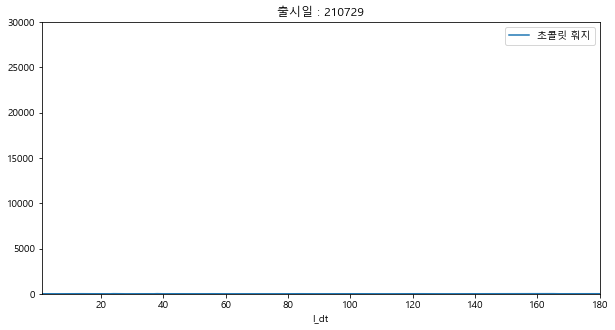

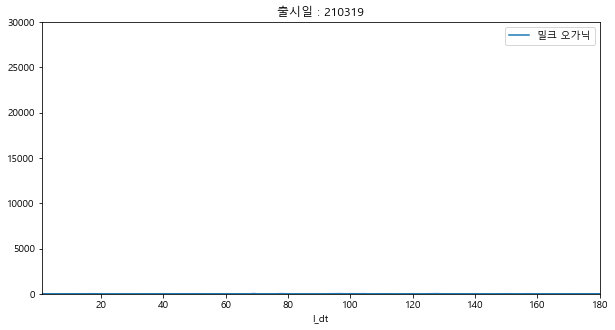

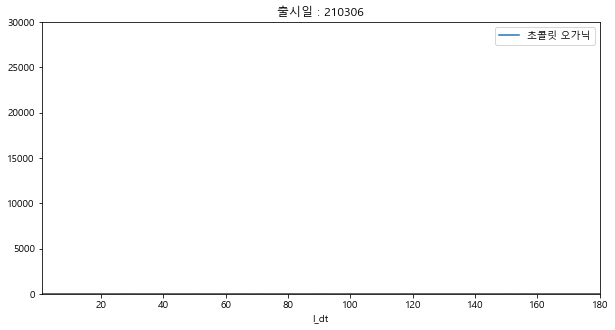

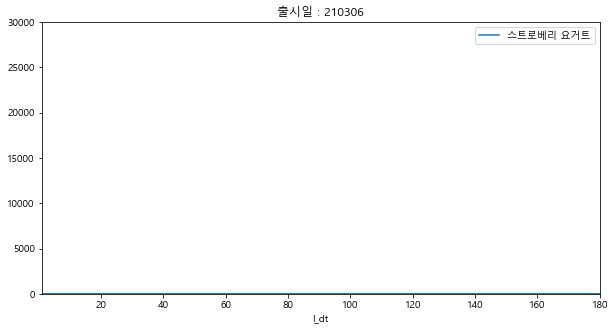

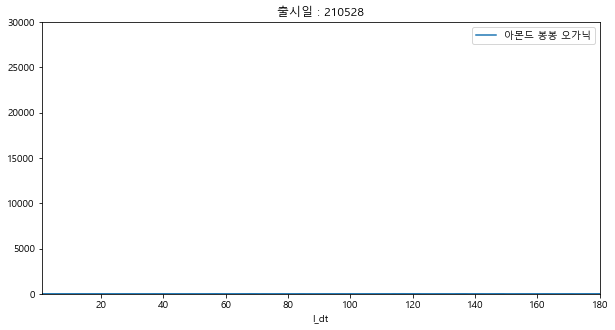

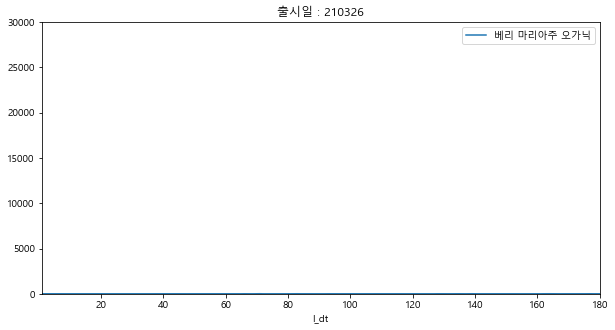

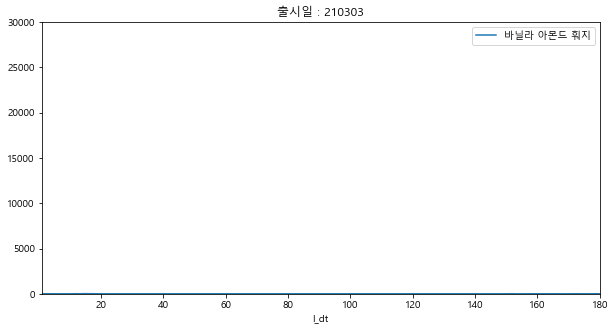

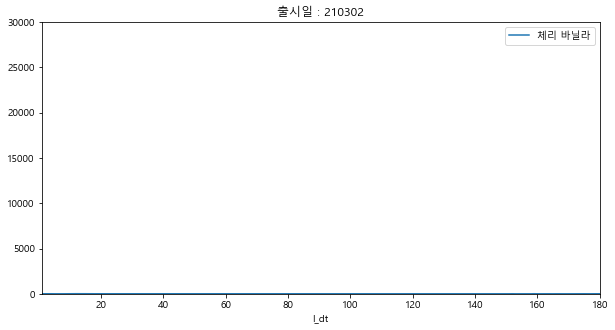

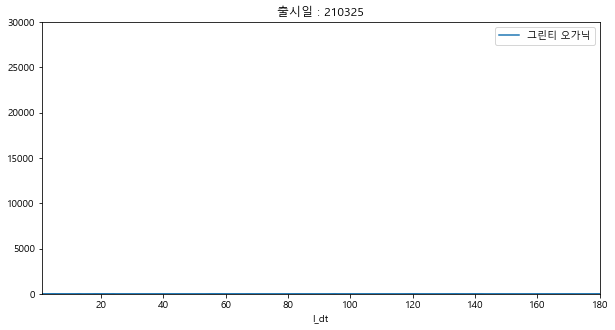

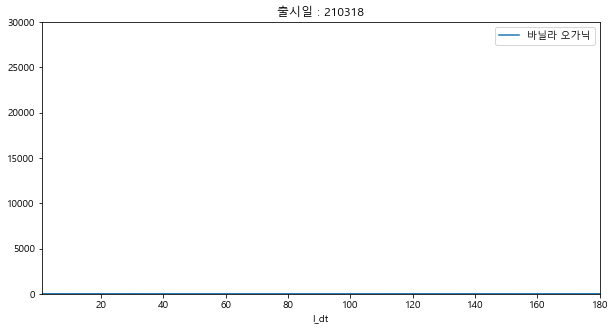

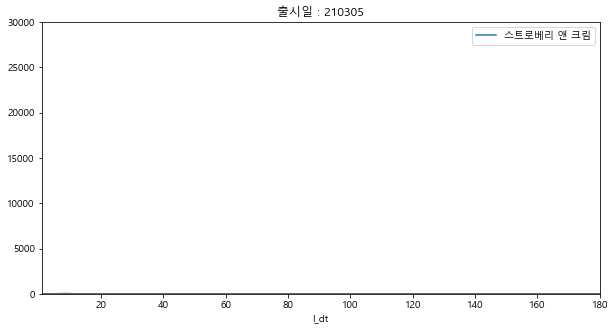

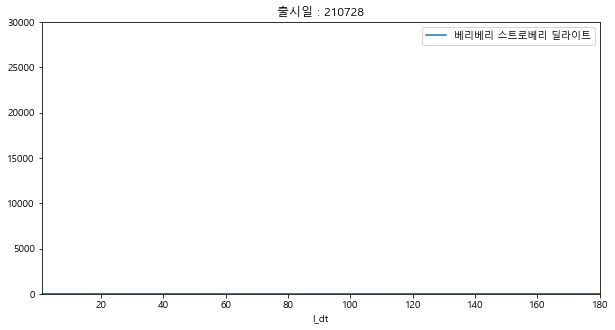

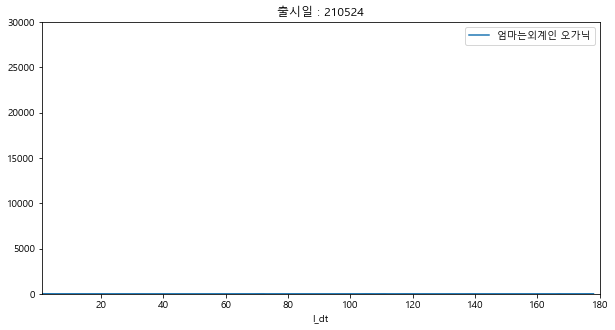

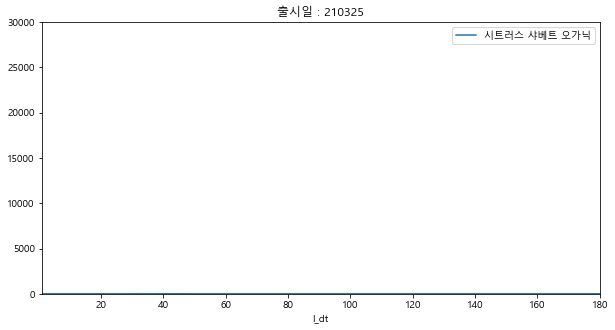

In [17]:
for idx, c in enumerate(new_30to80):
    # plt.subplot(6,5,idx+1)
    # df_sm[df_sm.ITEM_NM==c].plot(y = 'QTY', x ='l_dt', label = c, figsize = (10,5))
    title = df_m[df_m.ITEM_NM==c]['F_SALE_DT'].dt.strftime('%y%m%d').values[0]
    df_sm[df_sm.ITEM_NM==c].plot(y = 'QTY', x ='l_dt',title= f'출시일 : {title}' ,label = c, figsize = (10,5), xlim = [1,180], ylim = [0,30000])
    plt.savefig(f'./output/fom_lifecycle/t2_{idx+1}_fom_{c}.png', bbox_inches = 'tight')

### Flavor 소재 정보 정리

In [18]:
import pickle
flavor = pd.read_csv("fb.csv", encoding='euckr').fillna(0)

with open("item_dic_cd.pickle",'rb') as fr:
    item_dic_cd = pickle.load(fr)
    
#이름 통일하기
cd = list(flavor['BR#'])
flavor.loc[[c in item_dic_cd.keys() for c in cd],'DESCRIPTION'] = flavor[[c in item_dic_cd.keys() for c in cd]]['BR#'].apply(lambda x : item_dic_cd[x])
flavor

,BR#,DESCRIPTION,Category,아이스크림1,아이스크림2,아이스크림3,아이스크림4,컨펙션1,컨펙션2,컨펙션3,리본1,리본2
0,A50111,민트 초콜릿 칩,PERMANENT,페퍼민트,0,0,0,다크초콜릿,0,0,0,0
1,A56083,New 자모카 아몬드 훠지,PERMANENT,자모카(커피),0,0,0,볶음 아몬드반태,0,0,초콜릿,0
2,A50135,피스타치오 아몬드,PERMANENT,피스타치오,0,0,0,볶음 아몬드반태,0,0,0,0
3,A56035,아몬드 봉봉,PERMANENT,바닐라,0,0,0,초콜릿아몬드,0,0,밀크초콜릿,0
4,A56084,NEW 초콜릿 무스,PERMANENT,초콜릿무스,0,0,0,초콜릿칩(플레이크),0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
79,A56025,잘될거예엿,신제품\n(18-22년도),누가,0,0,0,크런치카라멜아몬드,0,0,엿리본,0
80,A56041,초코넛 마카다미아,신제품\n(18-22년도),밀크초콜릿,코코넛,0,0,구운마카다미아분태,0,0,밀크초콜릿리본,0
81,A56043,핑크러브,신제품\n(18-22년도),민트,민트,화이트초콜릿,0,구운피스타치오,0,0,0,0
82,A56046,할로윈 조커,신제품\n(18-22년도),피스타치오,타트체리 샤베트,0,0,0,0,0,0,0


In [19]:
flavor[flavor['BR#'] == 'A50122']

,BR#,DESCRIPTION,Category,아이스크림1,아이스크림2,아이스크림3,아이스크림4,컨펙션1,컨펙션2,컨펙션3,리본1,리본2


#### Flavor 테이블을 소재별로 Row 분해

In [20]:
# 형태 바꾸기 _ 모든 소재 모음

flavor_1 = flavor.copy()
flavor_1['소재'] = 0


for idx in range(len(flavor)):
    ls = []
    for c in range(3,12):
        if flavor_1.iloc[idx,c] != 0:
            ls.append(flavor_1.iloc[idx,[c]])
        else:
            pass
    if len(ls) !=0:
        flavor_1.loc[idx,'소재'] = ls
    else :
        pass


flavor_1.drop(['아이스크림1', '아이스크림2', '아이스크림3','아이스크림4', '컨펙션1', '컨펙션2', '컨펙션3', '리본1', '리본2'], axis = 1, inplace = True)
c = ['cd','nm','cat','ele']
flavor_1.columns  =c 
flavor_1


# 형태 바꾸기 _ 베이스 / 컨펙션 / 리본 모음

flavor['베이스'] = 0
flavor['컨펙션'] = 0
flavor['리본'] = 0

for idx in range(len(flavor)):
    ls = []
    for c in range(3,7):
        if flavor.iloc[idx,c] != 0:
            ls.append(flavor.iloc[idx,[c]])
        else:
            pass        
    flavor.loc[idx,'베이스'] = ls
    
for idx in range(len(flavor)):
    ls = []
    for c in range(7,10):
        if flavor.iloc[idx,c] != 0:
            ls.append(flavor.iloc[idx,[c]])
        else:
            pass 
    if len(ls) !=0:
        flavor.loc[idx,'컨펙션'] = ls
    else :
        pass
    
for idx in range(len(flavor)):
    ls = []
    for c in range(10,12):
        if flavor.iloc[idx,c] != 0:
            ls.append(flavor.iloc[idx,[c]])
        else:
            pass 
    if len(ls) !=0:
        flavor.loc[idx,'리본'] = ls
    else :
        pass
    
flavor.drop(['아이스크림1', '아이스크림2', '아이스크림3','아이스크림4', '컨펙션1', '컨펙션2', '컨펙션3', '리본1', '리본2'], axis = 1, inplace = True)
c = ['cd','nm','cat','base','conf', 'ribon']
flavor.columns = c 
flavor

,cd,nm,cat,base,conf,ribon
0,A50111,민트 초콜릿 칩,PERMANENT,[페퍼민트],[다크초콜릿],0
1,A56083,New 자모카 아몬드 훠지,PERMANENT,[자모카(커피)],[볶음 아몬드반태],[초콜릿]
2,A50135,피스타치오 아몬드,PERMANENT,[피스타치오],[볶음 아몬드반태],0
3,A56035,아몬드 봉봉,PERMANENT,[바닐라],[초콜릿아몬드],[밀크초콜릿]
4,A56084,NEW 초콜릿 무스,PERMANENT,[초콜릿무스],[초콜릿칩(플레이크)],0
...,...,...,...,...,...,...
79,A56025,잘될거예엿,신제품\n(18-22년도),[누가],[크런치카라멜아몬드],[엿리본]
80,A56041,초코넛 마카다미아,신제품\n(18-22년도),"[밀크초콜릿, 코코넛 ]",[구운마카다미아분태],[밀크초콜릿리본]
81,A56043,핑크러브,신제품\n(18-22년도),"[민트, 민트, 화이트초콜릿]",[구운피스타치오],0
82,A56046,할로윈 조커,신제품\n(18-22년도),"[피스타치오, 타트체리 샤베트]",0,0


신제품\n(18-22년도)    63
PERMANENT         21
Name: cat, dtype: int64


<AxesSubplot:>

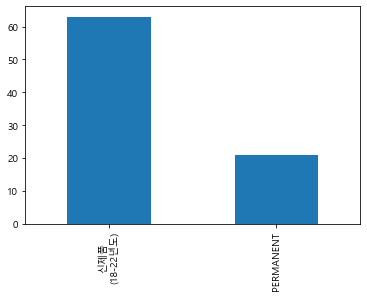

In [21]:
print(flavor.cat.value_counts())
flavor.cat.value_counts().plot(kind = 'bar')

### 아이스크림콘테스트

In [22]:
import pandas as pd

path = './dataset1/BR_2022_아이스크림 콘테스트_전체 참가작 리스트_최종.xlsx'
contest = pd.read_excel(path).fillna(0)
contest

,출품작이름,설명,첫번째 맛,두번째 맛,리본 1,리본 2,토핑 1,토핑 2
0,딸기를 먹으면 나한테 바나나,개인적으로 가장 좋아하는 조합이가도 하고 아이스크림은 호불호가 있으면 안된다 라고 ...,딸기,0,스트로베리,0,바나나,0
1,포근포근 블루베리 구름,배라 블루베리쥬빌레를 맛있게 먹었어서 블루베리 아이스크림을 먹고 싶어요!! 블루베리...,블루베리,요거트,블루베리,0,블루베리,0
2,엄마는 딸기를 좋아해,상큼한 베리베리스트로베리와 달달하고 바삭하게 씹히는 초코볼이 들어있는 엄마는 외계인...,밀크초콜릿,딸기,초콜릿,스트로베리,딸기,초코프레첼볼
3,통통팝핑냥,"저희 집 반려묘를 빗대어\n귀여운 아이보리색(바닐라)\n까맣고 귀여운 눈,코(초코)...",바닐라,다크초콜릿,스트로베리,0,팝핑캔디,초콜릿칩
4,톰과 제리,톰과 제리를 모티브함 흑임자는 톰을 월넛을은 제리를 나타냄,월넛,흑임자,카라멜,0,아몬드,월넛
...,...,...,...,...,...,...,...,...
69254,요거트 나라의 딸기바람,딸기와 요거트가 최고의 짝꿍인건 다들 아시죠? 네. 이제 배스킨라빈스가 일 낼 차례...,요거트,딸기,0,0,딸기,0
69255,쑥쑥 자랄레오,"쑥과 검은콩 크림의 고소함이 오레오와 어우러져 더 풍부한 맛을 내고, 화이트초코 프...",쑥,쿠키앤크림,쑥 크림,검은콩 크림,초콜렛쿠키(오레오),화이트초코 프레첼볼
69256,몰디브에서온모히또,"칵테일을 아이스크림으로 먹다.. 라임과 애플민트향, 달콤한꿀과 톡톡터지는 청량한토핑...",라임,애플민트,사이다,꿀,마시멜로,팝핑캔디
69257,오렌지 에스프레소,달콤한 커피 아이스크림과 상큼한 오렌지 샤베트에 쌉쌀한 에스프레소 리본!,커피,오렌지,에스프레소,0,0,0


In [23]:
# 소재별 이중리스트 생성
ls_rev = []
ls_base = []
ls_ribon = []
ls_topping = []
for idx in range(len(contest)):
    
    ls_r =[]
    for c in range(2,8):
        if (contest.iloc[idx, c] != 0) & (contest.iloc[idx, c] != '.'):
            ls_r.append(contest.iloc[idx,c])
        else:
            pass
        
    if len(ls_r) !=0:
        ls_rev.append(ls_r)
    else:
        pass  

    for c in range(2,4):
        if (contest.iloc[idx, c] != 0) & (contest.iloc[idx, c] != '.'):
            ls_base.append(contest.iloc[idx, c])
        else:
            pass
 
    for c in range(4,6):
        if (contest.iloc[idx, c] != 0) & (contest.iloc[idx, c] != '.'):
            ls_ribon.append(contest.iloc[idx,c])
        else:
            pass
       
    for c in range(6,8):
        if (contest.iloc[idx, c] != 0) & (contest.iloc[idx, c] != '.'):
            ls_topping.append(contest.iloc[idx,c])
        else:
            pass
    
ls_base_u = list(set(ls_base))
ls_ribon_u = list(set(ls_ribon))
ls_topping_u = list(set(ls_topping))

In [24]:
len(ls_base), len(ls_ribon), len(ls_topping),len(ls_base_u), len(ls_ribon_u), len(ls_topping_u)

(130559, 106311, 116687, 3439, 3607, 5728)

In [25]:
from apyori import apriori

li_item_apri = (list(apriori(ls_rev[:37000], min_support = 0.005)))
df_item_apri = pd.DataFrame(li_item_apri)
df_item_apri


df_item_apri['length'] =df_item_apri['items'].apply(lambda x : len(x))
df_g = df_item_apri[(df_item_apri['length'] >= 2) & 
          (df_item_apri['support'] >=0.01)].sort_values('support', ascending = False)
df_g = df_g.reset_index(drop=True)

In [26]:
import numpy as np

ls_rev_u = list(set(ls_base+ls_ribon+ls_topping))

color = {}
for a in ls_rev_u:
    if np.argmax([ls_base.count(a),ls_ribon.count(a),ls_topping.count(a)]) == 0:
        color[a]= 0.8
    elif np.argmax([ls_base.count(a),ls_ribon.count(a),ls_topping.count(a)]) == 1:
        color[a]= 0.5
    else:
        color[a]= 0.2

In [51]:
df_g.loc[172,'ordered_statistics'][0]

OrderedStatistic(items_base=frozenset(), items_add=frozenset({'꿀', '피스타치오'}), confidence=0.013, lift=1.0)

In [52]:
df_g

,items,support,ordered_statistics,length
0,"(딸기, 스트로베리)",0.103405,"[((), (딸기, 스트로베리), 0.10340540540540541, 1.0), ...",2
1,"(초콜릿, 초콜릿칩)",0.069405,"[((), (초콜릿, 초콜릿칩), 0.06940540540540541, 1.0), ...",2
2,"(초콜릿, 초코프레첼볼)",0.058568,"[((), (초콜릿, 초코프레첼볼), 0.05856756756756757, 1.0)...",2
3,"(블루베리, 스트로베리)",0.055189,"[((), (블루베리, 스트로베리), 0.05518918918918919, 1.0)...",2
4,"(크래클퍼지리본, 초코프레첼볼)",0.051514,"[((), (크래클퍼지리본, 초코프레첼볼), 0.05151351351351351, ...",2
...,...,...,...,...
268,"(피스타치오, 초코프레첼볼)",0.010108,"[((), (피스타치오, 초코프레첼볼), 0.010108108108108109, 1...",2
269,"(바나나, 딸기)",0.010081,"[((), (바나나, 딸기), 0.010081081081081082, 1.0), (...",2
270,"(딸기, 꿀, 스트로베리)",0.010081,"[((), (딸기, 꿀, 스트로베리), 0.010081081081081082, 1....",3
271,"(크래클퍼지리본, 스트로베리)",0.010081,"[((), (크래클퍼지리본, 스트로베리), 0.010081081081081082, ...",2


In [ ]:
import networkx as nx
G = nx.Graph()



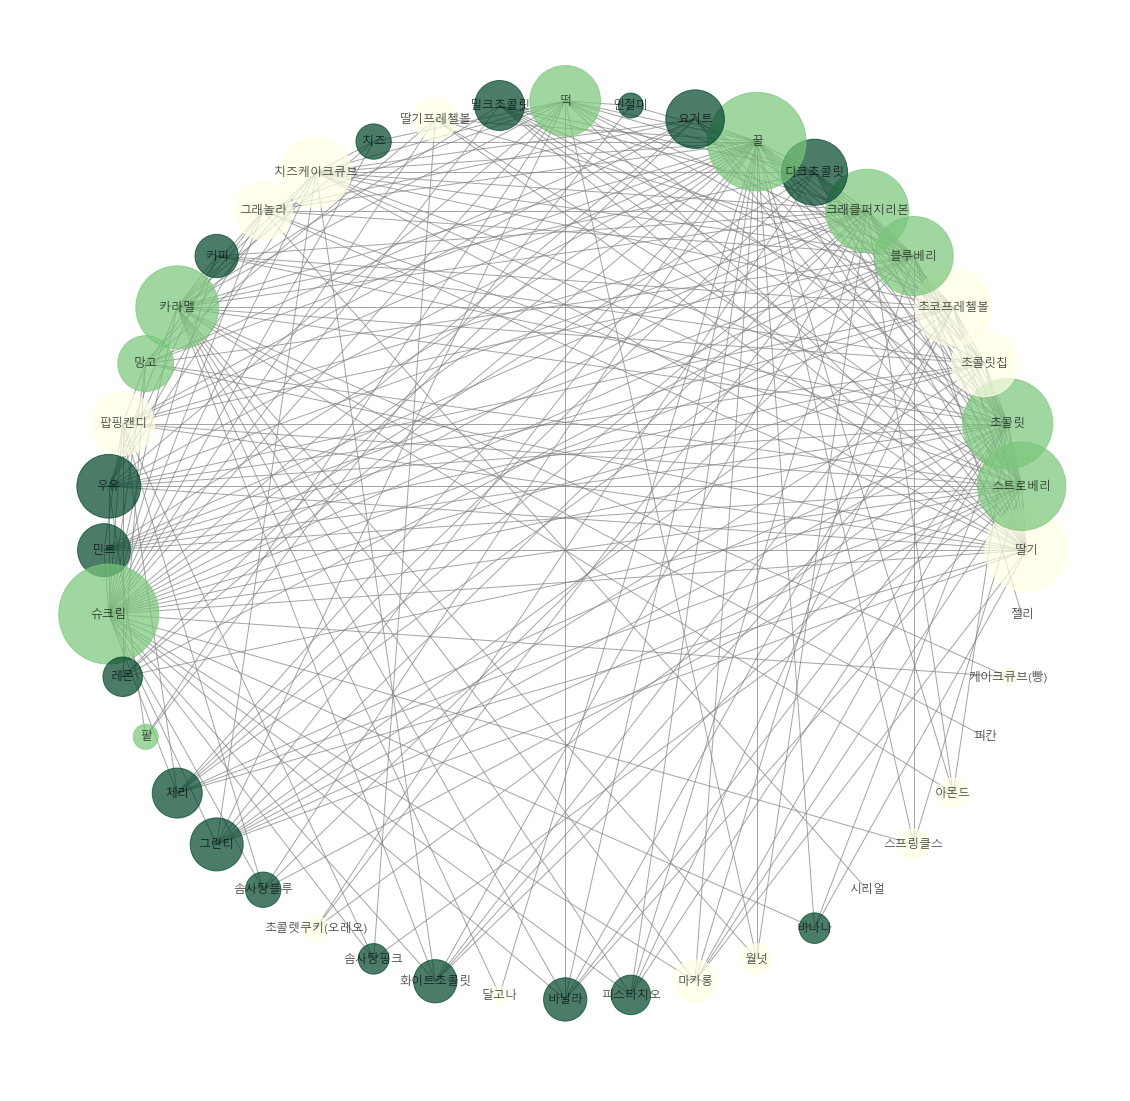

In [61]:
import numpy as np
import networkx as nx
import operator

G = nx.Graph()

# 엣지(선) 생성, 지지도의 역점수를 weight로 넣음 (지지도 높을수록 가까워지도록)
for idx in range(len(df_g)):
    G.add_edge(list(df_g['ordered_statistics'][idx][0][1])[0],list(df_g['ordered_statistics'][idx][0][1])[1], weight = 1/( df_g['ordered_statistics'][idx][0][2]))

# 노드 크기는 연결중심성을 통해 중요도에 따라 가중치 (제품의 등장빈도수)
dgr = nx.degree_centrality(G) 
sorted_dgr = sorted(dgr.items(), key = operator.itemgetter(1), reverse= True)

# 노드 색상은 소재 종류에 따라 부여 : 짙은 녹색 - 베이스로 많이 추천, 연두색 - 리본으로 많이추천, 노란색 -토핑으로 많이 추천
color_d = {r:color[r] for r in dgr.keys()}


## 레이아웃
# pos = nx.random_layout(dgr, seed = 15) # 페이지랭크로 레이아웃 결정
# pos = nx.shell_layout(dgr)
# pos = nx.bipartite_layout(dgr)
# pos = nx.circular_layout(dgr)
# pos = nx.spring_layout(dgr)
pos = nx.kamada_kawai_layout(dgr)


# for i in range(len(sorted_pgr)):
#     G.add_node(sorted_pgr[i][0], nodesize = sorted_dgr[i][1]*100)

nsize = np.array([v for v in dgr.values()]) # 노드 크기는 연결중심성 
nsize = 10000 * (nsize -min(nsize)) / (max(nsize)- min(nsize))       

                               
path = 'C:/Windows/Fonts/malgun.ttf' 
fontprop = fm.FontProperties(fname=path,size=18).get_name()

plt.figure(figsize = (20,20))
plt.axis('off')
nx.draw_networkx(G,pos = pos, node_color = list(color_d.values()), node_size = nsize,
                 alpha =0.7, edge_color = '.5', cmap = plt.cm.YlGn, font_family=fontprop)
plt.savefig('./output/kamada_kaway_layout.png', bbox_inches = 'tight')

In [58]:
G

In [29]:
# 두개 항목 조합 Top 50
df_g[['items','support']].sort_values('support',ascending=False)[:50]

,items,support
0,"(딸기, 스트로베리)",0.103405
1,"(초콜릿, 초콜릿칩)",0.069405
2,"(초콜릿, 초코프레첼볼)",0.058568
3,"(블루베리, 스트로베리)",0.055189
4,"(크래클퍼지리본, 초코프레첼볼)",0.051514
5,"(딸기, 블루베리)",0.047838
6,"(다크초콜릿, 크래클퍼지리본)",0.047297
7,"(초콜릿, 다크초콜릿)",0.046838
8,"(꿀, 요거트)",0.046514
9,"(초콜릿칩, 크래클퍼지리본)",0.043270


In [30]:
# 세개 항목 조합 Top 100
df_g3 = df_item_apri[(df_item_apri['length'] >= 3) & 
          (df_item_apri['support'] >=0.01)].sort_values('support', ascending = False)
df_g3[['items','support']][:50]

,items,support
581,"(딸기, 딸기프레첼볼, 스트로베리)",0.028270
590,"(딸기, 블루베리, 스트로베리)",0.027865
571,"(초콜릿, 다크초콜릿, 초콜릿칩)",0.022568
655,"(초콜릿, 초콜릿칩, 크래클퍼지리본)",0.020486
645,"(초콜릿, 크래클퍼지리본, 초코프레첼볼)",0.019324
621,"(초콜릿, 밀크초콜릿, 초코프레첼볼)",0.018432
568,"(다크초콜릿, 크래클퍼지리본, 초코프레첼볼)",0.018351
574,"(초콜릿칩, 다크초콜릿, 크래클퍼지리본)",0.018054
642,"(초콜릿, 초콜릿칩, 초코프레첼볼)",0.017838
565,"(초콜릿, 다크초콜릿, 초코프레첼볼)",0.017324


In [31]:
df_item_apri[(df_item_apri['length'] >= 4)].sort_values('support', ascending = False)

,items,support,ordered_statistics,length
676,"(초콜릿, 초콜릿칩, 크래클퍼지리본, 초코프레첼볼)",0.008973,"[((), (초콜릿, 초콜릿칩, 크래클퍼지리본, 초코프레첼볼), 0.00897297...",4
670,"(초콜릿, 크래클퍼지리본, 다크초콜릿, 초콜릿칩)",0.008730,"[((), (초콜릿, 크래클퍼지리본, 다크초콜릿, 초콜릿칩), 0.008729729...",4
668,"(초콜릿, 다크초콜릿, 크래클퍼지리본, 초코프레첼볼)",0.007892,"[((), (초콜릿, 다크초콜릿, 크래클퍼지리본, 초코프레첼볼), 0.0078918...",4
667,"(초콜릿, 다크초콜릿, 초콜릿칩, 초코프레첼볼)",0.007189,"[((), (초콜릿, 다크초콜릿, 초콜릿칩, 초코프레첼볼), 0.0071891891...",4
673,"(초콜릿, 밀크초콜릿, 크래클퍼지리본, 초코프레첼볼)",0.006703,"[((), (초콜릿, 밀크초콜릿, 크래클퍼지리본, 초코프레첼볼), 0.0067027...",4
671,"(딸기, 딸기프레첼볼, 블루베리, 스트로베리)",0.006622,"[((), (딸기, 딸기프레첼볼, 블루베리, 스트로베리), 0.00662162162...",4
675,"(초콜릿, 밀크초콜릿, 초콜릿칩, 크래클퍼지리본)",0.006622,"[((), (초콜릿, 밀크초콜릿, 초콜릿칩, 크래클퍼지리본), 0.006621621...",4
672,"(초콜릿, 밀크초콜릿, 초콜릿칩, 초코프레첼볼)",0.006486,"[((), (초콜릿, 밀크초콜릿, 초콜릿칩, 초코프레첼볼), 0.0064864864...",4
669,"(초콜릿칩, 다크초콜릿, 크래클퍼지리본, 초코프레첼볼)",0.005919,"[((), (초콜릿칩, 다크초콜릿, 크래클퍼지리본, 초코프레첼볼), 0.005918...",4
674,"(밀크초콜릿, 초콜릿칩, 크래클퍼지리본, 초코프레첼볼)",0.005081,"[((), (밀크초콜릿, 초콜릿칩, 크래클퍼지리본, 초코프레첼볼), 0.005081...",4


In [ ]:
df_item_apri.sort_values('support', ascending = False)